<a href="https://colab.research.google.com/github/mart-anthony-stark/Machine-Learning-and-Deep-Learning/blob/main/Fake_News_Detection_PH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection PH
Dataset: https://huggingface.co/datasets/fake_news_filipino

Task: text-classification NLP

Contains 3,206 expertly-labeled news samples, half of which are real and half of which are fake.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import missingno
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix

# Data Exploration

In [2]:
df = pd.read_csv('fakenews_data_ph.csv')

In [3]:
df.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


In [4]:
df.tail()

,label,article
3201,1,Hindi pa nai-enjoy ni Giacomo Filibeck ang Pil...
3202,1,"Sa isang pahayag, binatikos ng Liberal Party (..."
3203,1,Panoorin nyo yung reaction video na ito ni Mr....
3204,1,Para sa mga magkakapatid na laging nagtatalo l...
3205,1,Grabe ibang klase talaga si Vice Ganda kung ma...


In [5]:
df.describe()

,label
count,3206.000000
mean,0.500000
std,0.500078
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


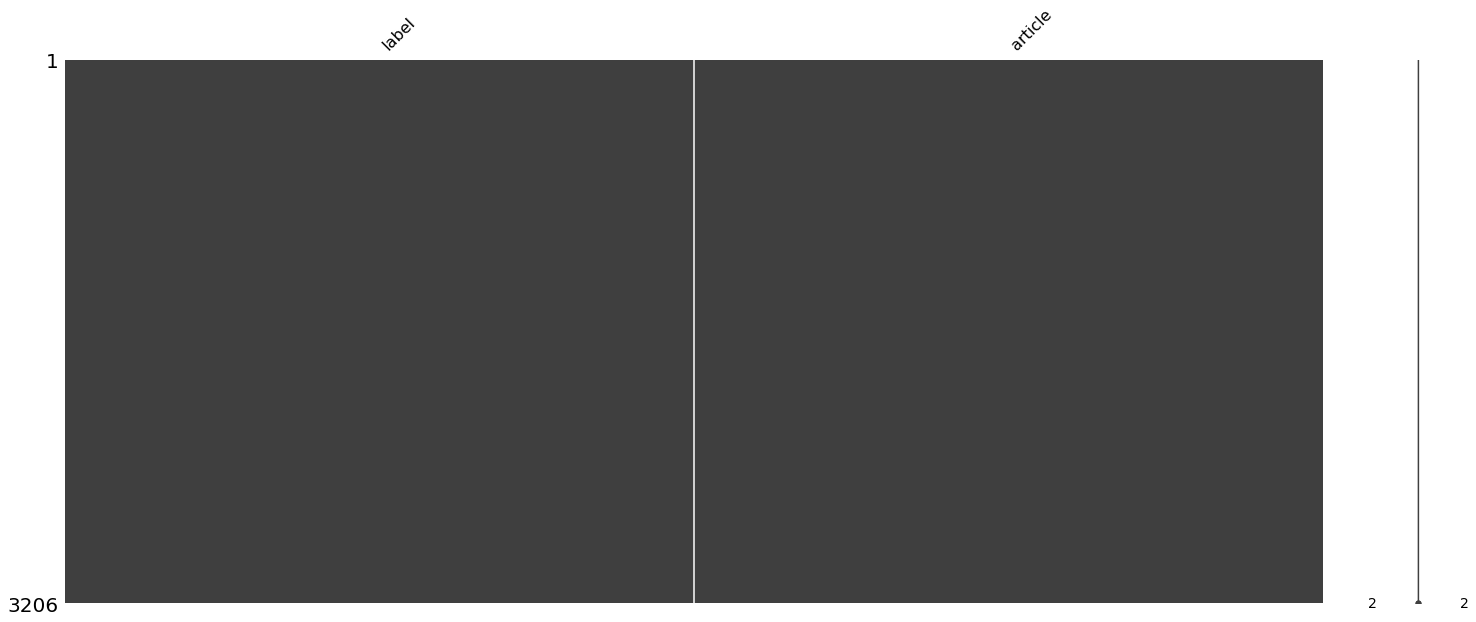

Missing: 0


In [6]:
missingno.matrix(df)
plt.show()
print("Missing: {}".format(df.isna().sum().sum()))

## Shuffling Dataset

In [7]:
from sklearn.utils import shuffle

df = shuffle(df).reset_index(drop=True)

In [8]:
df.head()

,label,article
0,1,Normal na sa pamilyang Pilipino na kapag may m...
1,0,Namatay sina Adis at Godayon habang ginagamot ...
2,1,"Sa isang panayam, tatlong buwan na ang nakarar..."
3,0,ARESTADO ang isang lalaki nang makuhaan ng 20 ...
4,0,"Sa pahayag ni MMDA Chairman Francis Tolentino,..."


In [9]:
df.tail()

,label,article
3201,0,Sa kasong pumukaw ng galit sa publiko at pangu...
3202,1,"Sa isang speaking engagement sa Malabon, gumam..."
3203,1,Usap-usapan ngayon sa social media ang umano'y...
3204,0,"""Tita ko ang nagma-manufacture, meron din kami..."
3205,0,IDINAAN sa malakas na tawa ng bida ng MMFF ent...


In [10]:
df.loc[3201, 'article'] # 0

'Sa kasong pumukaw ng galit sa publiko at pangungutya sa kanyang pagtrato sa flight crew, pinagalitan ni Heather Cho, anak ng chairman ng kumpanya at pinuno ng in-flight service, ang cabin crew chief at isa sa kanyang mga flight attendant na naghain sa kanya ng nuts na nakalagay sa supot, at hindi sa plato.'

In [11]:
df.loc[3202, 'article'] # 1

'Sa isang speaking engagement sa Malabon, gumamit na ng bullet-proof glass panel ang mga taga Presidential Security Group (PSG) para masigurado ang seguridad ng Pangulong Rodrigo DUterte laban sa mga may balak magtangka sa buhay ng Presidente. "Whether the threats are real or imagined, we take them seriously and the Palace commends the PSG for doing a good job," sabi Presidential Spokesperson Savador Panelo. Isa sa mga dahilan sa paggamit ng PSG ng bullet-proof glass ay ang pagiging "open area" ng lugat na pinagdausan ng event. Ayon kay Panelo, tungkulin ng PSG na bigyan ng pinakamataas na uri ng proteksyon ang Preisdente. At kailangan nni Presidente Duterte na sumunod sa security protocols sa ayaw at gusto nito. "PRRD is, however, bound by security protocols and, whether he likes it or not, these protocols are mandatorily attached to the position he holds," paliwanag ni Panelo. Hindi rin daw lingid sa kaalaman ng lahat na maraming nakakabangga ang Pangulo dahil sa pagbabago gusto ipat

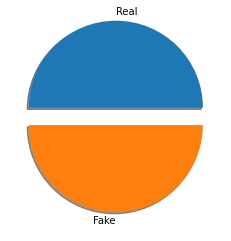

Real news count:  1603
Fake news count:  1603


In [12]:
# 1 == Fake and 0 == Real
real_news = len(df[df['label'] == 0])
fake_news = len(df[df['label'] == 1])
plt.pie([real_news, fake_news], labels=['Real', 'Fake'], explode = [0.2,0.0] , shadow=True)
plt.show()

print("Real news count: ", real_news)
print("Fake news count: ", fake_news)

# Data Preprocessing

## Converting text to lowercase

In [13]:
df['article'] = df['article'].apply(lambda txt: txt.lower())

In [14]:
df.head()

,label,article
0,1,normal na sa pamilyang pilipino na kapag may m...
1,0,namatay sina adis at godayon habang ginagamot ...
2,1,"sa isang panayam, tatlong buwan na ang nakarar..."
3,0,arestado ang isang lalaki nang makuhaan ng 20 ...
4,0,"sa pahayag ni mmda chairman francis tolentino,..."


## Removing Punctuations

In [15]:
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
def remove_punctuation(txt):
  all_list = [char for char in txt if char not in string.punctuation]
  return ''.join(all_list)

In [17]:
df['article'] = df['article'].apply(remove_punctuation)

In [18]:
df.head()

,label,article
0,1,normal na sa pamilyang pilipino na kapag may m...
1,0,namatay sina adis at godayon habang ginagamot ...
2,1,sa isang panayam tatlong buwan na ang nakarara...
3,0,arestado ang isang lalaki nang makuhaan ng 20 ...
4,0,sa pahayag ni mmda chairman francis tolentino ...


## Removing stopwords

Stop words are the words in a stop list which are filtered out before or after processing of natural language data because they are insignificant. Examples of stop words in English are “a”, “the”, “is”, “are” and etc.

### English Stopwords

In [19]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

df['article'] = df['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,label,article
0,1,normal na sa pamilyang pilipino na kapag may m...
1,0,namatay sina adis godayon habang ginagamot sa ...
2,1,sa isang panayam tatlong buwan na ang nakarara...
3,0,arestado ang isang lalaki nang makuhaan ng 20 ...
4,0,sa pahayag ni mmda chairman francis tolentino ...


### Tagalog Stopwords

In [20]:
tl_stopwords = []
with open('stopwords-tl.txt') as topo_file:
    for line in topo_file:
        tl_stopwords.append(line.replace('\n', ''))
tl_stopwords.extend(['ba', 'eh', 'kasi', 'lang', 'mo', 'naman', 'opo', 'po', 'si', 'talaga', 'yung'])

In [21]:
print(tl_stopwords)

['akin', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano', 'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'bababa', 'bago', 'bakit', 'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din', 'dito', 'doon', 'gagawin', 'gayunman', 'ginagawa', 'ginawa', 'ginawang', 'gumawa', 'gusto', 'habang', 'hanggang', 'hindi', 'huwag', 'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan', 'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyong', 'ka', 'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang', 'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan', 'katiyakan', 'katulad', 'kaya', 'kaysa', 'ko', 'kong', 'kulang', 'kumuha', 'kung', 'laban', 'lahat', 'lamang', 'likod', 'lima', 'maaari', 'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat', 'masyado', 'may', 'mayroon', 'mga', 'minsan', 'mismo', 'mula', 'muli', 'na', 'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'namin', 'napaka', 'narito', 'nasaan', 'ng', 'ngayon', 'ni', 'nila',

In [22]:
df['article'] = df['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (tl_stopwords)]))
df.head()

,label,article
0,1,normal pamilyang pilipino pagkakataong nangang...
1,0,namatay sina adis godayon ginagamot kalinga pr...
2,1,panayam tatlong buwan nakararaan ibinahagi ila...
3,0,arestado lalaki nang makuhaan 20 baril daandaa...
4,0,pahayag mmda chairman francis tolentino sinabi...


## Visualizing Frequent Word Occurrency

In [23]:
from wordcloud import WordCloud

is_fake = df['label'] == 1
fake_data = df[is_fake]
real_data = df[~is_fake]

Fake News


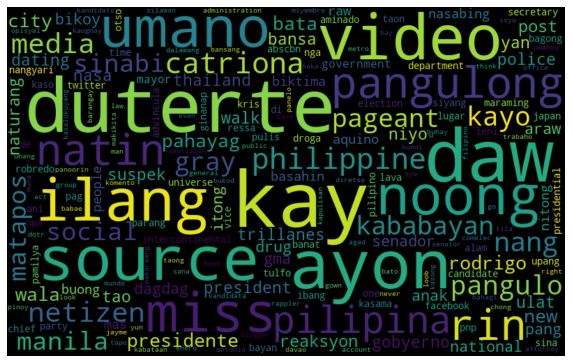

In [24]:
all_words = ' '.join([text for text in fake_data.article])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
print("Fake News")

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Real News


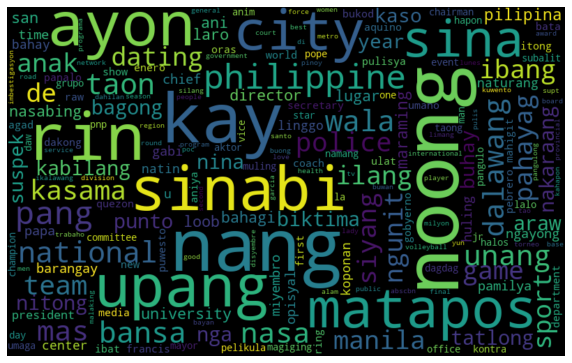

In [25]:
print("Real News")
all_words = ' '.join([text for text in real_data.article])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Most frequent words counter

In [26]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
  all_words = ' '.join([text for text in text[column_text]])
  token_phrase = token_space.tokenize(all_words)
  frequency = nltk.FreqDist(token_phrase)
  df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                  "Frequency": list(frequency.values())})
  df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
  plt.figure(figsize=(12,8))
  ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
  ax.set(ylabel = "Count")
  plt.xticks(rotation='vertical')
  plt.show()

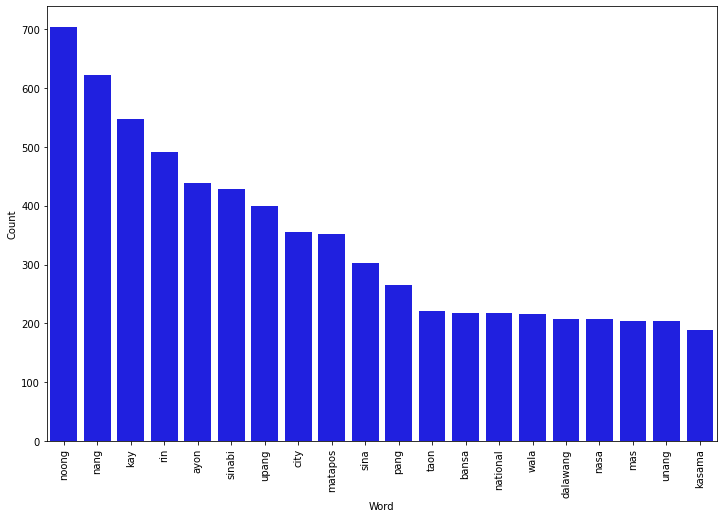

In [27]:
counter(df[df["label"] == 0], "article", 20)

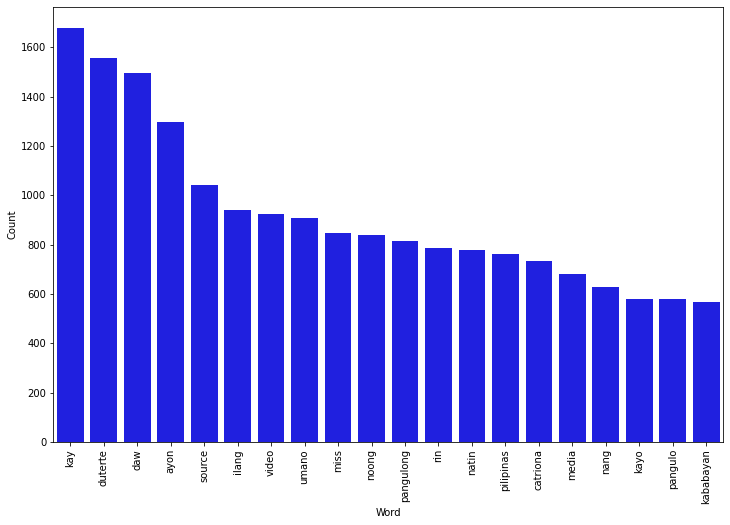

In [28]:
counter(df[df["label"] == 1], "article", 20)

# Model Development

## Splitting Data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df['article'], df['label'], test_size=0.2, random_state=42)

In [30]:
X_train.shape, y_train.shape

((2564,), (2564,))

In [31]:
X_test.shape, y_test.shape

((642,), (642,))

## Selecting Base Model

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier

models = {
    'DecisionTree': DecisionTreeClassifier(),
    'NaiveBayes': MultinomialNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'BaggingClassifier': BaggingClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier()
}

results = []
for name, model in models.items():
  pipeline = Pipeline([
                    ('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', model)
                    ])
  pipeline.fit(X_train, y_train)
  prediction = pipeline.predict(X_test)
  print("{} accuracy: {}%".format(name, round(accuracy_score(y_test, prediction)*100,2)))

DecisionTree accuracy: 91.12%
NaiveBayes accuracy: 91.74%
KNeighborsClassifier accuracy: 90.34%
RandomForestClassifier accuracy: 93.93%
AdaBoostClassifier accuracy: 94.7%
BaggingClassifier accuracy: 92.99%
GradientBoostingClassifier accuracy: 93.15%
ExtraTreesClassifier accuracy: 95.33%


## Hyperparameter Tuning

In [ ]:
# pipeline = Pipeline([
#                     ('vect', CountVectorizer()),
#                     ('tfidf', TfidfTransformer()),
#                     ('model', ExtraTreesClassifier())
#                     ])

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
# param_grid = {
#     "model__random_state": [0, 1, 2, 3, 4],   # [0, 1, 2, 3, 4],
#     "model__n_estimators": [320, 340, 360, 380, 400], # [320, 340, 360, 380, 400],
#     "model__max_depth": [25, 30, 32, 34, 38, 45]      # [25, 30, 32, 34, 38, 45]
# }

# grid_search = GridSearchCV(pipeline, scoring='accuracy', cv=cv, param_grid=param_grid, verbose=True)
# # grid_search.get_params().keys()
# grid_search.fit(X_train, y_train)

In [ ]:
# print("Best score: %0.3f" % grid_search.best_score_)
# print("Best parameters set:")
# best_parameters = grid_search.best_estimator_.get_params()
# for param_name in sorted(param_grid.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [33]:
pipeline = Pipeline([
                    ('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', ExtraTreesClassifier())
                    ])

## Fitting the model

In [34]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', ExtraTreesClassifier())])

## Predicting testing dataset

In [35]:
predictions = pipeline.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, predictions)*100,2)))

accuracy: 94.7%


In [36]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Confusion matrix, without normalization


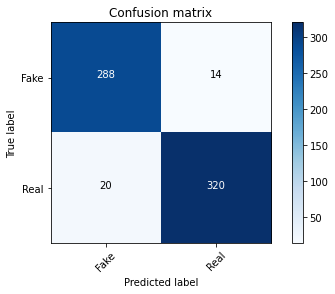

In [37]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Saving the ML pipeline

In [38]:
import pickle

pickle.dump(pipeline, open('ph_fake_news_pipeline.pkl', 'wb'))

In [78]:
mapped_dict = {'real': 0, 'fake': 1}
mapped_list = list(mapped_dict.keys())

news_one = "Sa isang speaking engagement sa Malabon, gumamit na ng bullet-proof glass panel ang mga taga Presidential Security Group (PSG) para masigurado ang seguridad ng Pangulong Rodrigo DUterte laban sa mga may balak magtangka sa buhay ng Presidente."
news_two = "MANILA - Lawmakers from the Makabayan coalition on Saturday vowed to keep scrutinizing the slashing of funds in the proposed 2023 national budget for education, health, social assistance, and agriculture."

clf_pipeline = pickle.load(open('ph_fake_news_pipeline.pkl', 'rb'))

In [85]:
def remove_punctuation(txt):
  all_list = [char for char in txt if char not in string.punctuation]
  return ''.join(all_list)

def remove_en_stopwords(txt):
  return ' '.join([word for word in txt.split() if word not in (en_stopwords)])

def remove_tl_stopwords(txt):
  tl_stopwords = []
  with open('stopwords-tl.txt') as topo_file:
      for line in topo_file:
          tl_stopwords.append(line.replace('\n', ''))
  tl_stopwords.extend(['ba', 'eh', 'kasi', 'lang', 'mo', 'naman', 'opo', 'po', 'si', 'talaga', 'yung'])
  return ' '.join([word for word in txt.split() if word not in (tl_stopwords)])


def preprocess_data(txt):
  txt = txt.lower()
  txt = remove_punctuation(txt)
  txt = remove_en_stopwords(txt)
  txt = remove_tl_stopwords(txt)
  return txt

In [98]:
data = news_one
processed_data = preprocess_data(data)
data_arr = np.array([processed_data])

news_prediction = clf_pipeline.predict(data_arr)

pred = mapped_list[list(news_prediction)[0]]
probability = clf_pipeline.predict_proba(data_arr)[0] * 100

In [100]:
pred, probability

('fake', array([43., 57.]))

In [101]:
data = news_two
processed_data = preprocess_data(data)
data_arr = np.array([processed_data])

news_prediction = clf_pipeline.predict(data_arr)

pred = mapped_list[list(news_prediction)[0]]
probability = clf_pipeline.predict_proba(data_arr)[0] * 100

In [102]:
pred, probability

('real', array([81., 19.]))